<a href="https://colab.research.google.com/github/muga01/TMAWrapper/blob/main/PCA_TSNE_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Description

It happens that time is not on our side. We need to make a quick decision on certain matters as quickly as possible. Developers intending to re-use or implement exact text searching algorithms often ask themselves on which algorithm we should pick out of the many algorithms available. They manually test each algorithm to find the one providing the fastest speed based on their test case. This is a lengthy process demanding resources and time. We propose a tool in which based on the test case, the user is proposed with the fastest exact text searching algorithm in no time. This way developers concentrate in more advanced tasks which require human presence and expertise. 

# Data quick check




## Data Load

In [ ]:
#!pip install pandas-bokeh
# !pip install ipympl
# !pip install plotly

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request
import pandas as pd
import seaborn as sns
import panel as pn
import panel.widgets as pnw
from matplotlib.figure import Figure
from matplotlib.ticker import ScalarFormatter
import warnings
warnings.filterwarnings("ignore")
pn.extension()
#import pandas_bokeh
#pandas_bokeh.output_notebook()
# %matplotlib inline
# %matplotlib widget

In [ ]:
# Dataset URL Parameters
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/muga01/TMAWrapper/main/'
DATASET_PATH = 'dataset'
DATASET_TOKEN ='token=GHSAT0AAAAAABVV3RXUBBRPTI7KBVQWYV2MYXLOTPA'
DATASET_URL = DOWNLOAD_ROOT + 'dataset/string_pattern_matching.csv?'+DATASET_TOKEN

def fetch_matching_data(dataset_source=DATASET_URL,dataset_dest=DATASET_PATH):
    os.makedirs(dataset_dest,exist_ok=True)
    dataset_file_name = os.path.join(dataset_dest,'string_pattern_matching.csv')
    data = urllib.request.urlretrieve(dataset_source,dataset_file_name)

def load_matching_data(data_source_path=DATASET_PATH):
    csv_path = os.path.join(data_source_path,'string_pattern_matching.csv')
    return pd.read_csv(csv_path)

In [ ]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Experiments"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
fetch_matching_data()
matching_data = load_matching_data()
matching_data.head()

,Category,Text Size [MB],Pattern Length,Alphabet Size,Time [ms],Algorithm,Best Algo
0,rand2,1.0,2,2.0,0.00,AOSO2,NaN
1,rand2,1.0,4,2.0,14.37,AOSO2,NaN
2,rand2,1.0,8,2.0,6.56,AOSO2,NaN
3,rand2,1.0,16,2.0,1.83,AOSO2,NaN
4,rand2,1.0,32,2.0,1.33,AOSO2,NaN


## Data Cleaning

In [ ]:
matching_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category        8640 non-null   object 
 1   Text Size [MB]  8640 non-null   float64
 2   Pattern Length  8640 non-null   int64  
 3   Alphabet Size   8640 non-null   float64
 4   Time [ms]       8640 non-null   float64
 5   Algorithm       8640 non-null   object 
 6   Best Algo       488 non-null    object 
dtypes: float64(3), int64(1), object(3)
memory usage: 472.6+ KB


We observe the column Best Algo missing some values. This is intentional as for each test experiment that is for different combinations of [text category, text size, pattern length, alphabet size] each algorithm reports it's speed and among all those speeds the best one is placed under the column Best Algo. We will train our model based on Best Algo label.

# Data Exploration and Visualization

## Dataset High Level Information

In [ ]:
matching_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category        8640 non-null   object 
 1   Text Size [MB]  8640 non-null   float64
 2   Pattern Length  8640 non-null   int64  
 3   Alphabet Size   8640 non-null   float64
 4   Time [ms]       8640 non-null   float64
 5   Algorithm       8640 non-null   object 
 6   Best Algo       488 non-null    object 
dtypes: float64(3), int64(1), object(3)
memory usage: 472.6+ KB




*   The dataset contains 8640 instances with 7 columns.
*   The dataset has 4 numerical and 3 categorical/string attributes
*The Best Algo column has null values.



## Statistical distribution of numerical attributes

In [ ]:
matching_data.describe()

,Text Size [MB],Pattern Length,Alphabet Size,Time [ms]
count,8640.00000,8640.000000,8640.00000,8640.000000
mean,16.50000,204.600000,74.00000,51.541698
std,19.60343,312.985907,70.47393,123.266517
min,1.00000,2.000000,2.00000,0.000000
25%,4.00000,8.000000,14.00000,2.520000
50%,7.50000,48.000000,64.00000,9.810000
75%,20.00000,256.000000,128.00000,41.532500
max,50.00000,1024.000000,250.00000,1554.760000




*   We have an algorithm(s) which took close to 1.5s to look for a pattern.
*   We only have positive numbers thus we will have more scaling options including logarithmic based.



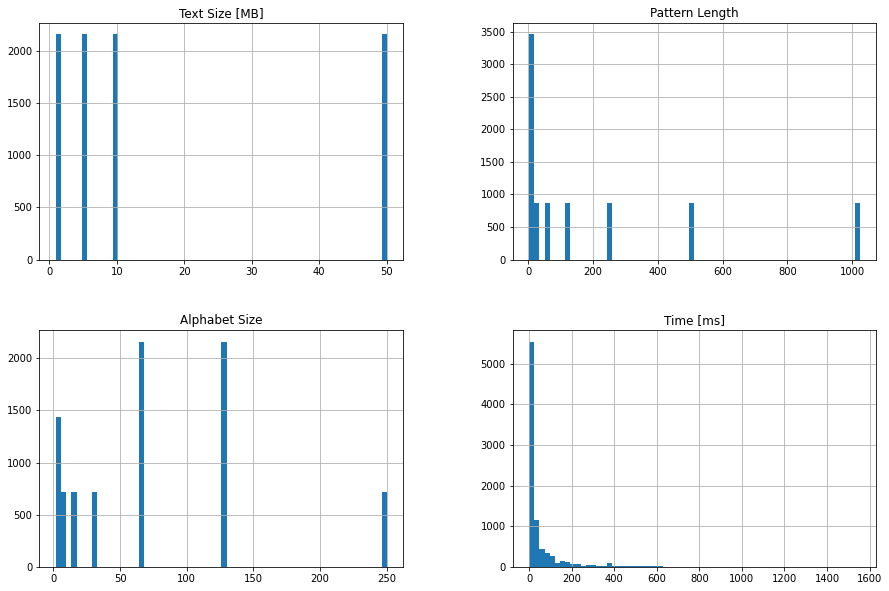

In [ ]:
_=matching_data.hist(bins=64,figsize=(15,10))



*   The attributes have different scales except pattern length and Alphabet size which looks like they follow the same scale.
* Time attribute follows exponential curve.



## Categorical attributes distribution

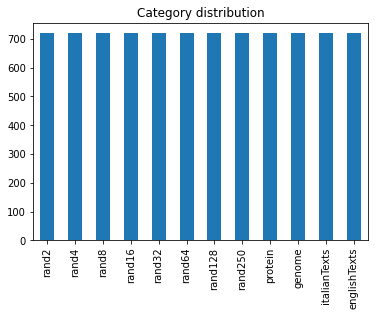

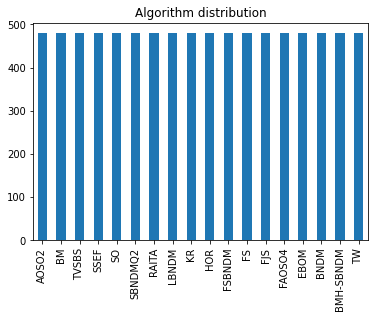

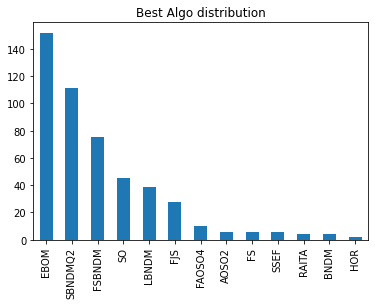

In [ ]:
column_names = ['Category','Algorithm','Best Algo']

for col in column_names:
    plt.figure()
    plt.title(f'{col} distribution')
    _=matching_data[col].value_counts().plot(kind='bar')
    
    


Starting from top to bottom plot:-
*   All text samples have equal representation. The settings based on two constraints one was the corpus availability and second was the shared memory limitations.
*   Well, nothing much to talk about the second plot. The algorithms are equally represented which means each and every algorithm was tested in each experiment.
* The third plot has a lot to talk about. First, it represents the number of times a particular algorithm beats its competitors in a test experiment. Generally, we observe that EBOM algorithm won in most cases while HOR was the last. Later we can deep dive into trying to locate under which test cases an algorithm is strong or weak. Second, did you spot that BM,TVSBS, KR, BMH-SBNDM and TW algorithms are missing in the third plot? Well, that means they never won the race in any of the test experiment.

* Also, we need to be careful during training and testing dataset splitting. We don't want some algorithms to miss in either of the split as this would hinder performance and hence model generalization. Looking at the third plot it's likely that we may fall into this trap. Random based splitting techniques may not work perfectly for this case. We shall see🤞

* Finally, A closer look at the third plot suggests at the very beginning that accuracy might not be a good measure of performance, the dataset is badly unbalanced. Maybe we can fine tune the classification threshold as the standard one is set to `0.5`. Time ⌚ will tell.



## A quick look ➿ at the SMART dataset, once and for all.

We create an interactive dashboard to help get insights about the smart dataset. What we can get from this dashboard:-


1.   Get a quick look at the algorithm performance under different conditions.
2.   Get to know which algorithm is the best under the specified conditions (The Ground Truth).
3.   Multiple performance plots can be added into one canvas and visualize which one is performing better.

Tips on how to use the dashboard.

⚠  Avoid setting variables to zero, unless it's intentional. For example, if you set the text size variable to `0` you loose the plot (The middle panel).

🆗 Set the Alphabet Size and Pattern Length to `0` (The right panel on the dashboard) to investigate on algorithm(s) performance. BTW, you can set as you wish and suit yourself.

⛔ To determine the best algorithm (The Ground Truth) ensure Text Size, Category, Alphabet Size and Pattern Length variables are selected. The result will be shown underneath the Pattern Length variable. If it's not the current plot on the canvas you can visualize the best algorithm by selecting it in the left panel (Algorithm variable).

🆒 Widget values/options are being updated automatically based on what you options you select. For example setting alphabet size to `0` then the pattern length is reset to `0` too. Setting different `text sizes` updates the `alphabet size` choice list, and so on.




In [ ]:
# !pip install panel -q # An Interactive Dashboard

In [ ]:
#!pip install panel -q # An Interactive Dashboard
# We might consider transforming to OOP in the future
# let's get the job done first
# import plotly.express as px
def data_plots(data):
    if data.size == 0:
        return ''

    fig = Figure()
    ax = fig.add_subplot()
    sns.lineplot(data=data,
                 x="Pattern Length",
                 y="Time [ms]",
                 hue='Algorithm',
                 ax=ax,
                 marker='o',
                 estimator='mean')
    ax.set_xscale('log', basex=2)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.grid(True)

    return fig

def group_data(algorithm=["FSBNDM"],textSize=1,category=["englishTexts"],view_fn=data_plots):
    df = matching_data.query('Algorithm in @algorithm & `Text Size [MB]`==@textSize &Category in @category')
    return view_fn(df)

def bestAlgo(df):
    if df.size != 0:
        return pn.pane.Markdown(object=f'Fastest: {df["Algorithm"][0]}')
    return ''
    

def best_algo(category="englishTexts",textSize=1,patternLength=8,alphabetSize=64,view_fn=bestAlgo):
    q = 'Category in @category & `Text Size [MB]`==@textSize & `Pattern Length` ==@patternLength & `Alphabet Size`==@alphabetSize'
    df = matching_data.query(q).sort_values(by='Time [ms]',ignore_index=True)
    return view_fn(df)

def options(txt_size):
    q = matching_data.query('`Text Size [MB]`==@txt_size')
    alph_size = sorted(list(q['Alphabet Size'].unique())+[0])
    cat = list(q['Category'].unique())
    return alph_size,cat

def alpha_options(curr_alpha,curr_size):
    if curr_alpha != 0:
        q = matching_data.query('`Text Size [MB]`==@curr_size & `Alphabet Size`==@curr_alpha')
        return list(q['Category'].unique())
    return list((matching_data['Category'].unique()))

# Defining a parameter Watcher
def callback(*events):
    for event in events:
        if event.name == 'value':
            alph_size,cat = options(event.new)
            alphabet_size.options = alph_size
            category.options = category.value = cat

def callback_alpha(*events):
    for event in events:
        if event.name == 'value':
            category.value = category.options = alpha_options(event.new,text_size.value)
            if event.new == 0: pattern_length.value = 0

# Creating widgets
## Widgets Global variables
algorithm  = pnw.MultiSelect(name='Algorithm', value=['FSBNDM'], 
                                options=list(matching_data['Algorithm'].unique()))
text_size  = pnw.Select(name='Text Size', value=None, 
                                options=sorted(list(matching_data['Text Size [MB]'].unique())+[0]))
category = pnw.MultiSelect(name='Category', value=list(matching_data['Category'].unique()),
                        options=list((matching_data['Category'].unique())))
alphabet_size = pnw.Select(name='Alphabet Size', value=None,
                                options=sorted(list(matching_data['Alphabet Size'].unique())+[0]))
pattern_length = pnw.Select(name='Pattern Length', value=None,
                                options=sorted(list(matching_data['Pattern Length'].unique())+[0]))
def left_pane():
    text = "\n# Parameter Settings\nApply different set of filters" #<br>
    headers_l = pn.Column(text, algorithm, text_size,category,width=300)
    mid_plot = pn.bind(group_data, algorithm, text_size,category)
    return headers_l,mid_plot

def right_pane():
    # GROUND TRUTH
    text_ground ="""\n# Ground truth\nDetermine the fastest algorithm
    by changing Alphabet size, Pattern length, 
    Text size and Category."""
    # reactive_plot = pn.bind(group_data, algorithm, text_size,category)
    best_algo_name = pn.bind(best_algo,category,text_size,pattern_length,alphabet_size)
    headers_r = pn.Column(text_ground,alphabet_size,pattern_length,best_algo_name,width=200)
    return headers_r


def set_up_main_panel():
    headers_l , mid_plot = left_pane()
    headers_r = right_pane()
    return pn.Row(headers_l,mid_plot,headers_r)

def text_size_watcher():
    return text_size.param.watch(callback, ['value'], onlychanged=True) 

def trig_text_event():
    # Ensure we have the default mid plot
    text_size.value = 1

def alphabet_size_watcher():
    return alphabet_size.param.watch(callback_alpha, ['value'], onlychanged=True) 



Row
    [0] Column(width=300)
        [0] Markdown(str)
        [1] MultiSelect(name='Algorithm', options=['AOSO2', 'BM', ...], value=['FSBNDM'])
        [2] Select(name='Text Size', options=[0, 1.0, 5.0, 10.0, 50.0], value=1)
        [3] MultiSelect(name='Category', options=['rand2', 'rand4', ...], value=['rand2', 'rand4', ...])
    [1] ParamFunction(function)
    [2] Column(width=200)
        [0] Markdown(str)
        [1] Select(name='Alphabet Size', options=[0, 2.0, 4.0, ...], value=0)
        [2] Select(name='Pattern Length', options=[0, 2, 4, 8, 16, ...], value=0)
        [3] ParamFunction(function)
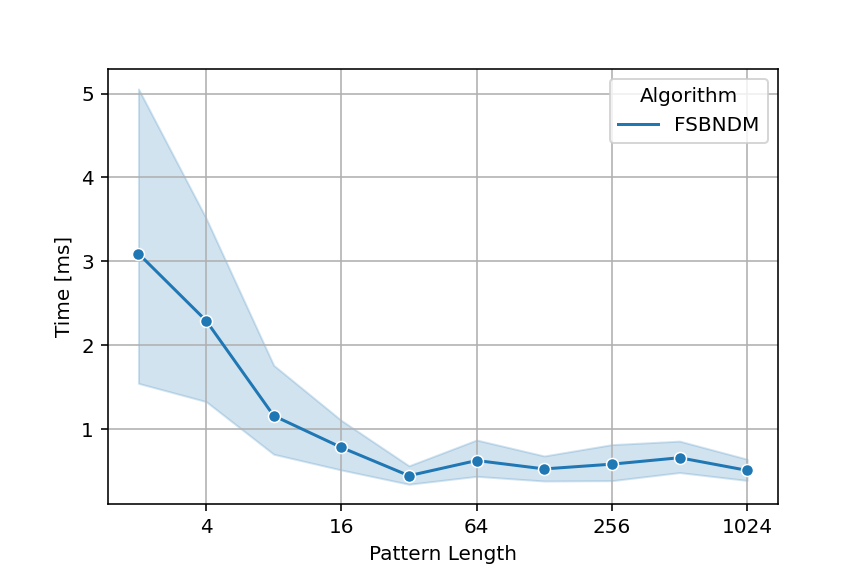

In [ ]:
visualizer = set_up_main_panel() # The Entire Dashboard
watch_text_size = text_size_watcher() # Track text size Changes
trig_text_event() # Trigger text size event to have a default mid plot
watch_alphabet_size = alphabet_size_watcher() # Track alphabet_size
visualizer

## A closer look at the 🔝 four best performing algorithms.

We already know from the previous section that `FSBNDM`,`EBOM`,`SBNDMQ2`, and `SO`are the top 4 performer in terms of search completion time. While it might be difficult to investigate the algorithm performances for all cases, lets check few of the scenarios:-


1.   Strengths and Weaknesses of the top 4 best performing algorithms when the `text sizes` and `pattern length` are varied.
2.   Same as `1` but when corpus(`Category`) is changed instead of `text sizes`.



In [ ]:
matching_data.columns

Index(['Category', 'Text Size [MB]', 'Pattern Length', 'Alphabet Size',
       'Time [ms]', 'Algorithm', 'Best Algo'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
best_only = matching_data[matching_data['Best Algo'].isna() == False]
cMap = OrdinalEncoder()
c = cMap.fit_transform(np.array(best_only['Best Algo']).reshape(-1,1))
cMap.categories_[0]

array(['AOSO2', 'BNDM', 'EBOM', 'FAOSO4', 'FJS', 'FS', 'FSBNDM', 'HOR',
       'LBNDM', 'RAITA', 'SBNDMQ2', 'SO', 'SSEF'], dtype=object)

In [ ]:
X =best_only[['Pattern Length','Alphabet Size','Best Algo']].groupby(['Best Algo']).count()['Pattern Length']
best_only['size']=best_only['Best Algo'].apply(lambda a:X[a])

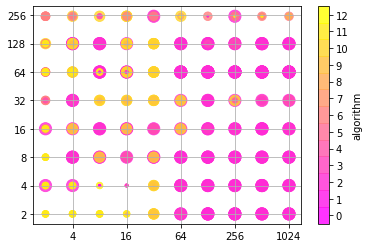

In [ ]:
# fig = Figure(figsize=(10,20))
fig,ax = plt.subplots()
img = ax.scatter(best_only[['Pattern Length']].values, 
           best_only[['Alphabet Size']].values,
           c=c,
           cmap=plt.cm.get_cmap('spring', 13),
           s = best_only['size'].values,
           alpha = 0.8,
           lw = 0.8,
              )
# plt.matshow(best_only[['Pattern Length','Alphabet Size']],cmap=c)
plt.colorbar(img,ticks=range(13), label='algorithm')
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.grid(True)
img.set_clim(-0.5, 12.5)

### Strengths💹 and Weaknesses📉 of the top 4 best performing algorithms when the `text sizes` and `pattern length` varies.

| Column: text size, Row: pattern length, <font color='green'>Cell: best algorithm</font> |
| -- |


| | 1 | 2 | 4 | 5 | 6.8 | 8 | 16 | 32 | 64 | 128 |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| 8 | FSBNDM | FSBNDM | FSBNDM | <font color='red'>**LBNDM**</font> | <font color='blue'>**FAOSO4**</font> | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM |
| 16 | FSBNDM | FSBNDM | FSBNDM | <font color='red'>**LBNDM**</font> | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM |
| 32 | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM |
| 64 | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | <font color='red'>**LBNDM**</font> | FSBNDM | FSBNDM |
| 128 | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | <font color='red'>**LBNDM**</font> | <font color='red'>**LBNDM**</font> | <font color='red'>**LBNDM**</font> |
| 256 | FSBNDM | FSBNDM | FSBNDM | <font color='red'>**LBNDM**</font> | <font color='red'>**LBNDM**</font> | <font color='blue'>**FAOSO4**</font> | <font color='red'>**LBNDM**</font> | <font color='red'>**LBNDM**</font> | <font color='red'>**LBNDM**</font> | <font color='red'>**LBNDM**</font> |

What we see in this table is that generally, the `FSBNDM` outperforms the rest of the algorithms especially when the `text size` is below `5`. Also it does better for all `text sizes` when the pattern length is `32`. We also observe other algorithms come into picture When `text size` is `5` and above. When the `pattern lengths` and `text sizes` are increased the FSBNDM seems to struggle while `LBNDM` excels but not entirely. Finally, `AOSO2` doesn't appear at this data summarization level. `FAOSO4` appears occasionally. Let's dig deeper to understand how these algorithms perform under different categories(corpuses). 


### Strengths💹 and Weaknesses📉 of the top 4 best performing algorithms when the `category` and `pattern length` varies.

| Row: category, Column: pattern length, cell: best algorithm, `text size = 1` |
| -- |

| | 8 | 16 | 32 | 64 | 128 | 256 |
| -- | -- | -- | -- | -- | -- | -- |
| rand2 | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM |
| rand4 | <font color='green'>**AOSO2**</font> | <font color='blue'>**FAOSO4**</font> | <font color='blue'>**FAOSO4**</font> | <font color='blue'>**FAOSO4**</font> | <font color='blue'>**FAOSO4**</font> | FSBNDM |
| rand8 | FSBNDM | <font color='blue'>**FAOSO4**</font> | FSBNDM | <font color='blue'>**FAOSO4**</font> | <font color='red'>**LNDBM**</font> | <font color='red'>**LNDBM**</font> |
| rand16 | FSBNDM | FSBNDM | FSBNDM | FSBNDM | <font color='red'>**LNDBM**</font> | <font color='red'>**LNDBM**</font> |
| rand32 | FSBNDM | FSBNDM | FSBNDM | FSBNDM | FSBNDM | <font color='red'>**LNDBM**</font> |
| rand64 | FSBNDM | <font color='red'>**LNDBM**</font> | FSBNDM | FSBNDM | <font color='red'>**LNDBM**</font> | <font color='red'>**LNDBM**</font> |
| rand128 | FSBNDM | FSBNDM | FSBNDM | FSBNDM | <font color='red'>**LNDBM**</font> | <font color='red'>**LNDBM**</font> |
| rand250 | FSBNDM | FSBNDM | FSBNDM | <font color='red'>**LNDBM**</font> | FSBNDM | FSBNDM |
| protein | FSBNDM | <font color='blue'>**FAOSO4**</font> | <font color='red'>**LNDBM**</font> | FSBNDM | FSBNDM | <font color='blue'>**FAOSO4**</font> |
| genome | <font color='green'>**AOSO2**</font> | <font color='blue'>**FAOSO4**</font> | <font color='blue'>**FAOSO4**</font> | <font color='blue'>**FAOSO4**</font> | <font color='blue'>**FAOSO4**</font> | <font color='green'>**AOSO2**</font> |
| italian | FSBNDM | <font color='blue'>**FAOSO4**</font> | FSBNDM | <font color='red'>**LNDBM**</font> | <font color='red'>**LNDBM**</font> | <font color='red'>**LNDBM**</font> |
| english | <font color='green'>**AOSO2**</font> | FSBNDM | <font color='blue'>**FAOSO4**</font> | <font color='green'>**AOSO2**</font> | <font color='red'>**LNDBM**</font> | FSBNDM |

We can tell a few words about this setup. First, generally the `FSBNDM` does pretty well except when the `text categories` are `rand4, rand8, genome,italian, english` texts. Second, it looks like `FSBNDM` the best performing algorithm does not understand `genome` texts at all. Third, the algorithms performance is almost balanced when the corpuses is from `english` texts. `FAOSO4` does well when the text categories are `rand4` and `genome` perhaps we can also say when `alphabet size` is `4`? because both these two have an alphabet size of `4`. Fourth, `LNDBM` performs quite well when the `pattern length` is high. Fifth, `AOSO2` the least performing algorithm among the four appears this time, it doesn't have any specific pattern. Finally, as you may already have imagined, it's not that simple to say this algorithm does better than the rest all depend on the provided circumstances. For example in our case we could have chosen to implement `FSBNDM` but what if we are searching on genome database for example, it could consume resources for long time unnecessary while we could have implemented `FAOSO4` instead. What if you seat back and let the simple tool help you decide in no time which algorithm to implement or to be run  based on the queries at hand?. Perfect! this table provided a glimpse on the need of that tool, because the algorithms behave differently under different conditions.

## Time to play Violin 🎻

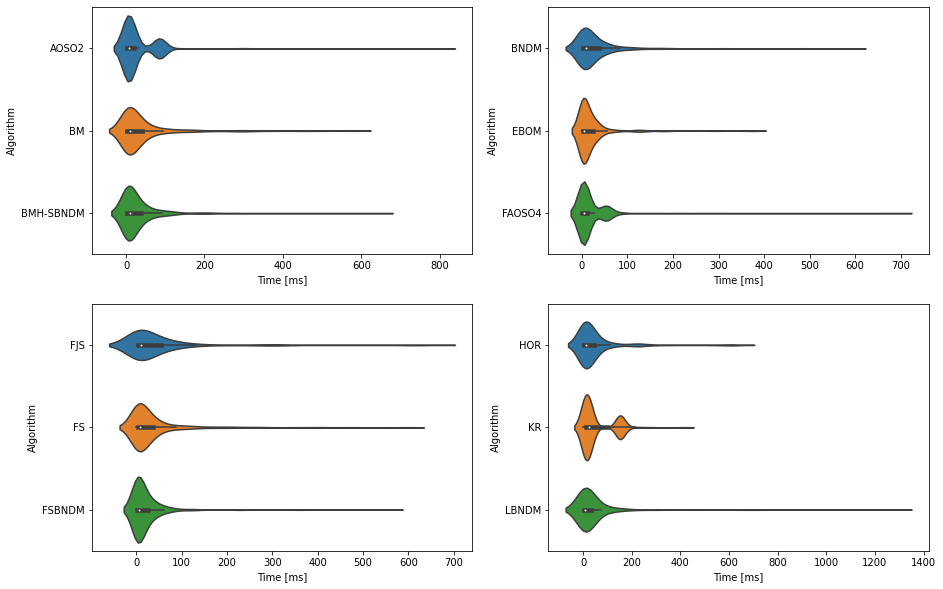

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(15,10))
ax = ax.flatten()
algos = matching_data['Algorithm'].unique()
# Total algo in play: 13
orders = algos.reshape(6,3)
orders = orders.tolist()
# The last algo included
#orders[-1] += [algos[-1]]
for i in range(len(ax)):
    sns.violinplot(data=matching_data, 
               x='Time [ms]',
               y="Algorithm",
               order=orders[i],
               ax=ax[i],
               )


Most of the algorithms are centered across the median with a very little distribution when time increases. Remember `BM`, `KR` and `TW` were not among the best algorithms? We can also observe from the violin plot that their tail extends further than their counterparts.

# Key take aways


1.   The algorithm distributions are right-skewed.[here](#scrollTo=TXug62-xzEu1) and [here](#scrollTo=hHjgYsbUWuHq)
2.   Attributes exhibit different scaling and there is a possibility to [apply log scales](#scrollTo=LSXqjPksi5uZ), etc.
3.   The time attribute immitates an [exponential](#scrollTo=7Yn8F8rp3DFb) distribution.
4.   `BM`,`KR` and `TW` didn't [win](#scrollTo=UvvpuD5KApeX) in either of the test experiments.
5.   Smart dataset is [uneven](#scrollTo=UvvpuD5KApeX) distributed. We must be careful when we split the data and choose the performance metrics.
6.   In most cases, `FSBNDM` algorithm seems to perform better than it's rivals especially when the corpus is [random](#scrollTo=QOyPhcUneE2B).
7.   The best algorithm `FSBNDM` seems not to quickly understand `genome` texts and competes [fairly](#scrollTo=QOyPhcUneE2B) with its rivals for the corpuses which are not random.
8.   The `LBNDM` second best algorithm performs better for higher [pattern](#scrollTo=QOyPhcUneE2B) lengths.
9.   The `FAOSO4` seems [better](#scrollTo=QOyPhcUneE2B) for `genome` and `rand4`



# Feature Engineering

Before marching forward, we can create additional features from the pre-existing ones. We have `time` and `text size` combining these two we may calculate the algorithm speeds using the formula: `speed = text size / time`

In [ ]:
# speed in GB/s
matching_data['speed'] = (matching_data['Text Size [MB]'] / matching_data['Time [ms]'])*1000/1024

# Modeling

In [ ]:
## Import important libraries
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit

## None Null Data

This time around we take a look at the actual data points for model development by simply ommiting the null from the `Best Algo` column.

In [ ]:
smart = matching_data[matching_data['Best Algo'].notnull()].reset_index()
smart.drop('index',axis=1,inplace=True)
smart.describe()

,Text Size [MB],Pattern Length,Alphabet Size,Time [ms],speed
count,488.000000,488.000000,488.000000,488.000000,488.000000
mean,16.245902,207.803279,74.479508,13.398689,1.899483
std,19.560389,315.583216,71.055691,21.253500,0.959434
min,1.000000,2.000000,2.000000,0.220000,0.464764
25%,1.000000,8.000000,14.000000,1.280000,1.169118
50%,5.000000,64.000000,64.000000,4.225000,1.860119
75%,10.000000,256.000000,128.000000,20.305000,2.441406
max,50.000000,1024.000000,250.000000,105.060000,4.438920


## Data clean up and transformation


### Dataset preprocessing pipeline for numerical features.

That's right we did add the speed during feature engineering step, however its a common practice to build a custom transformer to do just that. This transformation will later be part of an end to end transformation pipeline. We could have done it earlier but okay we will drop the `speed` feature and re-add using a novice technique. I promise not to touch the `strat_test` again until we are done with model development.

In [ ]:
# Later take a look here, comment out this code
for data in (strat_train,strat_test):
    data.drop('speed',axis=1, inplace=True)


Now `Algorithm` and `Best Algo` attributes looks similar, we can delete one of those. We delete `Best Algo`.

In [ ]:
smart_train = strat_train.drop('Best Algo',axis=1)

Next, we set aside the training features and label. It is not necessary that they exhibit the same transformations.

In [ ]:
smart_train.drop('Algorithm',axis=1,inplace=True) # Remove Algorithm from features its a label
smart_train_labels = strat_train['Algorithm'].copy()

Then, we remove categorical attributes from the train set as we can't scale on them.

In [ ]:
cat = ['Category']
smart_train_num = smart_train.drop(cat,axis=1,)

In [ ]:
smart_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 5 to 416
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Text Size [MB]  390 non-null    float64
 1   Pattern Length  390 non-null    int64  
 2   Alphabet Size   390 non-null    float64
 3   Time [ms]       390 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 15.2 KB


In [ ]:
smart_train_num

,Text Size [MB],Pattern Length,Alphabet Size,Time [ms]
5,1.0,32,2.0,0.74
12,5.0,128,2.0,3.93
426,5.0,32,128.0,2.87
303,5.0,4,250.0,3.25
158,50.0,4,16.0,55.41
...,...,...,...,...
314,10.0,1024,250.0,2.35
230,10.0,32,64.0,4.00
373,1.0,16,64.0,0.88
410,1.0,32,128.0,0.50


Our dataset seems to contain no missing entries, thus imputation may not be significant. Next, we decide to add more features. We define the custom transformer to perform this job. The class extends the `base` class from scikit-learn library. 

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
# txt_size_index = 0
# time_index = 3
txt_size_index,time_index = [smart_train_num.columns.get_loc(col) for col in ['Text Size [MB]','Time [ms]']]
print(txt_size_index,time_index)
class AttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,addSpeed=False,dropTime=True):
        self.addSpeed = addSpeed
        self.dropTime = dropTime
    
    def fit(self, X, y=None):
        return self

    def transform(self,X):
        if self.addSpeed:
            speed = (X.iloc[:,txt_size_index] / X.iloc[:,time_index]) * 1000/1024
            return np.c_[X,speed]
        if self.dropTime:
            return np.delete(X.values,time_index,1)
        return X

0 3


We noted previously that the samples are all positive and that they are right-skewed. In this case we may try to implement a log transformation. Two advantages here, we will be less affected by outliers and also the dataset could be normally distributed which is an important recipe to Machine Learning models. We will use scikit-Learn `FunctionTransformer` class to apply `np.log1p` transformation to the dataset. We could also have decided to implement our own scaling function as per above template class `AttributesAdder`

In [ ]:
from sklearn.preprocessing import FunctionTransformer
log_scaling = FunctionTransformer(func=np.log1p, validate=True)

Almost done with numerical data processing steps, Let's combine the two transformations we just did into one pipe. Ok, we make use of the `Pipeline` class from scikit-learn.

In [ ]:
from sklearn.pipeline import Pipeline
numerical_pipe = Pipeline([
                           ('add_drop_attributes',AttributesAdder()),
                           ('log_scaler',FunctionTransformer(func=np.log1p, validate=True))
])


Let's check how the numerical data looks like, before and after transformation.

In [ ]:
smart_train_num_tr = numerical_pipe.fit_transform(smart_train_num)
smart_train_num_tr

array([[0.69314718, 3.49650756, 1.09861229],
       [1.79175947, 4.8598124 , 1.09861229],
       [1.79175947, 3.49650756, 4.8598124 ],
       ...,
       [0.69314718, 2.83321334, 4.17438727],
       [0.69314718, 3.49650756, 4.8598124 ],
       [0.69314718, 2.19722458, 4.8598124 ]])

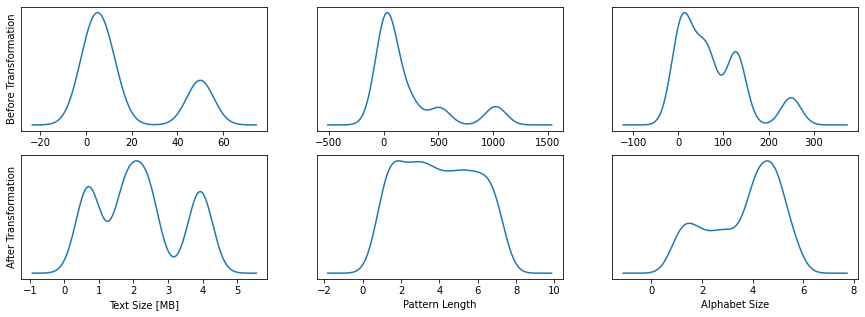

In [ ]:
# Plots

# num = ['Text Size [MB]','Pattern Length','Alphabet Size','Time [ms]','speed [GB/s]']
num = ['Text Size [MB]','Pattern Length','Alphabet Size']
smart_train_num_tmp = AttributesAdder().fit_transform(smart_train_num)
smart_train_num_tr_df = pd.DataFrame(smart_train_num_tr,columns=num)
smart_train_num_tmp_df = pd.DataFrame(smart_train_num_tmp,columns=num)
#print(smart_train_num_tmp)
fig,ax = plt.subplots(2,3,figsize=(15,5))
ax = ax.flatten()

for i in range(len(ax)):
    
    if (i<3):
        # Untransformed plots: First row
        smart_train_num_tmp_df[num[i]].plot(kind='kde',ax=ax[i])
        ax[i].set_ylabel('')
    else:
        # Transformed Plots: second row
        smart_train_num_tr_df[num[i-3]].plot(kind='kde',ax=ax[i])
        ax[i].set_xlabel(num[i-3])
        ax[i].set_ylabel('')
        
ax[0].set_ylabel('Before Transformation')
ax[3].set_ylabel('After Transformation')
for axix in ax:
    axix.tick_params(
        axis='y',
        which='both',
        left=False,
        labelleft=False,
    )


Looking at the plots (x-axis and the shape) we notice the scaling effect especially when the attributes are skewed. The log scale did try to normalize the data to follow gaussian normal distribution. There are quite a number of scaling options available, to mention a few of them: Min-Max, standard, robust, and power and log based scalers. We will revisit some of those options if need be as model performance could be affected with the scaler choice which in deed depends on the dataset at hand.

## Dataset preprocessing pipeline for categorical features.

In the previous section we developed a pipeline to first add additional attributes and second perform scaling on numerical features. In this section we try to encode the text enchriched `category` attribute. We can consider Label or one hot encoding methods. With the classical label encoder the categories are firstly sorted (not necessary though, you can create a custom one with your own rules) in ascending order and then each assigned an ordinal number from `0` to `n-1` where `n` is the total number of unique classes/categories available. This might not be a good approach into features representation as it might happen that a machine learning algorithm think that `0` and `1` are related to each other because they are close to each other, while in reality perhaps class `0` has a close relationship with class `10` for instance. The representation might be good in some use cases such as rating a product, it's true that 0 is related to 1 etc. In contrast, one hot encoders typically assigns `1` (hot) to this particular class and `0` (cold) to the rest. These additional attributes (zeros) are sometimes refered as dummy attributes. So all have equal weight in this case a machine learning algorithm won't make up things.

In this section apart from adopting a one-hot encoder from sklearn library, we also adopt `columnTransformer` class which helps us to apply transformations to individual columns we specify. We can also `drop` or `passthrough` columns we don't want to apply transformations. Let's see how it goes. Remember we split the dataset to train and test sets?, that's right, but we real messed with the copy of it. But now we want after data split, we hit straight to pipelines all done in a seemless way as below steps:-

1.   Drop unrequired attributes (`Best Algo`): automatically dropped
2.   Drop a label column (`Algorithm`): automatically dropped
3.   Drop Categorical feature (`Category`): automatically dropped
4.   Apply AttributesAdder transformer to add features (`speed`)
5.   Apply feature scaling using the `FunctionTransformer`
6.   Apply one-hot encoding to categorical features

That's it, features are ready for machine learning algorithms consumption. Later, we will take care of the label column, its categorical perhaps ordinal encoding will do the trick here and since we are not aiming at developing a `multi-output model` we won't do a one-hot encoding.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_attributes = ['Text Size [MB]','Pattern Length','Alphabet Size','Time [ms]']
cat_attributes = ['Category']

features_full_pipeline = ColumnTransformer([
                                            ("num_attr",numerical_pipe,num_attributes),
                                            ("cat_attr",OneHotEncoder(),cat_attributes),
])

In [ ]:
# Both Train and Test Sets
full_set = strat_train.append(strat_test)
print(full_set.shape)

(488, 7)


In [ ]:
smart_features = features_full_pipeline.fit_transform(full_set)

In [ ]:
smart_features.shape

(488, 15)

One last thing, Let's encode the smart dataset labels.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

labels_full_pipeline = Pipeline([
                         ('labels',OrdinalEncoder())
])

smart_labels = labels_full_pipeline.fit_transform(full_set['Algorithm'].values.reshape(-1,1))

In [ ]:
smart_labels.shape

(488, 1)

In [ ]:
labels_full_pipeline['labels'].categories_

[array(['AOSO2', 'BNDM', 'EBOM', 'FAOSO4', 'FJS', 'FS', 'FSBNDM', 'HOR',
        'LBNDM', 'RAITA', 'SBNDMQ2', 'SO', 'SSEF'], dtype=object)]

## How do algorithm separate from each other.
Let us check how distant the algorithms are from each other using PCA.

In [ ]:
smart_features
smart_features.toarray().shape

(488, 15)

In [ ]:
# Transform dataset --> (488,4,4)
tr_smart_features = np.append(smart_features.toarray(),np.zeros((488,1)),axis=1)
tr_smart_features.shape

(488, 16)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(10)
f_pca = pca.fit_transform(tr_smart_features)
f_pca.shape

(488, 10)

Saving figure PCA


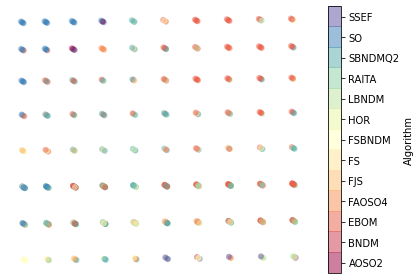

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
t_features = pca.fit_transform(smart_features.toarray())
fig,ax = plt.subplots()
img=ax.scatter(t_features[:, 0], t_features[:, 1],
            c=smart_labels, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 13))
plt.xlabel('component 1')
plt.ylabel('component 2')
img.set_clim(-0.5, 12.5)
clb = plt.colorbar(img,ticks=range(13), label='Algorithm')
clb.set_ticklabels(labels_full_pipeline['labels'].categories_[0])
_=plt.axis("off")
save_fig('PCA')

Saving figure PCA plus TSNE


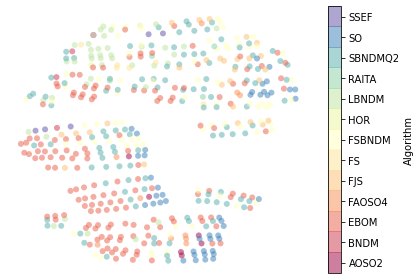

In [ ]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(tr_smart_features)
tx, ty = tsne[:,0], tsne[:,1]
fig,ax = plt.subplots()
img=ax.scatter(tx, ty,
            c=smart_labels, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 13))
plt.xlabel('component 1')
plt.ylabel('component 2')
img.set_clim(-0.5, 12.5)
clb = plt.colorbar(img,ticks=range(13), label='Algorithm')
clb.set_ticklabels(labels_full_pipeline['labels'].categories_[0])
_=plt.axis("off")
save_fig('TSNE')

### AUTOENCODER

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers,losses
from tensorflow.keras.models import Model
from numpy.random import seed
seed(2022)
tf.random.set_seed(2022)


In [ ]:
latent_dim = 2
class AutoEncoder(Model):
    def __init__(self,latent_dim) -> None:
        super(AutoEncoder,self).__init__()
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential(
            [
             layers.Dense(8,activation='relu'),
            #  layers.Dense(4,activation='relu'),
             layers.Dense(latent_dim,activation='relu')]
        )

        self.decoder = tf.keras.Sequential(
            [
            #  layers.Dense(4,activation='sigmoid'),
             layers.Dense(8,activation='sigmoid'),
             layers.Dense(15,activation='sigmoid')]
        )

    def call(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
x_train = smart_features.toarray()/255.

In [ ]:
autoencoder = AutoEncoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train,x_train,
                epochs=20,
                shuffle=True,
                validation_data=[x_train,x_train]
                )

Epoch 1/20
16/16 [==============================] - 4s 13ms/step - loss: 0.2605 - val_loss: 0.2498
Epoch 2/20
16/16 [==============================] - 0s 5ms/step - loss: 0.2414 - val_loss: 0.2311
Epoch 3/20
16/16 [==============================] - 0s 5ms/step - loss: 0.2231 - val_loss: 0.2133
Epoch 4/20
16/16 [==============================] - 0s 5ms/step - loss: 0.2057 - val_loss: 0.1964
Epoch 5/20
16/16 [==============================] - 0s 5ms/step - loss: 0.1892 - val_loss: 0.1803
Epoch 6/20
16/16 [==============================] - 0s 7ms/step - loss: 0.1735 - val_loss: 0.1651
Epoch 7/20
16/16 [==============================] - 0s 5ms/step - loss: 0.1586 - val_loss: 0.1506
Epoch 8/20
16/16 [==============================] - 0s 7ms/step - loss: 0.1444 - val_loss: 0.1368
Epoch 9/20
16/16 [==============================] - 0s 5ms/step - loss: 0.1309 - val_loss: 0.1237
Epoch 10/20
16/16 [==============================] - 0s 5ms/step - loss: 0.1181 - val_loss: 0.1113
Epoch 11/20
16/16 

In [ ]:
# Display encoded results
encoded = autoencoder.encoder(x_train).numpy()
decoded = autoencoder.decoder(encoded).numpy()
encoded[:5]

array([[1.3787038 , 0.78438294],
       [1.3897064 , 0.7901789 ],
       [1.3934257 , 0.7914258 ],
       [1.3864818 , 0.7878002 ],
       [1.3985372 , 0.7982265 ]], dtype=float32)

Saving figure Autoencoder


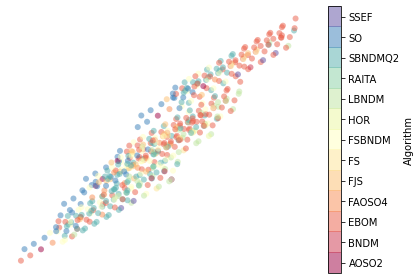

In [ ]:
tx, ty = encoded[:,0], encoded[:,1]
fig,ax = plt.subplots()
img=ax.scatter(tx, ty,
            c=smart_labels, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 13))
plt.xlabel('component 1')
plt.ylabel('component 2')
img.set_clim(-0.5, 12.5)
clb = plt.colorbar(img,ticks=range(13), label='Algorithm')
clb.set_ticklabels(labels_full_pipeline['labels'].categories_[0])
_=plt.axis("off")
save_fig('Autoencoder')

In [ ]:
# autoencoder.encoder.summary()

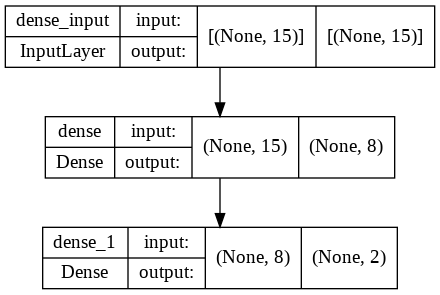

In [ ]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(autoencoder.encoder, to_file=dot_img_file, show_shapes=True)

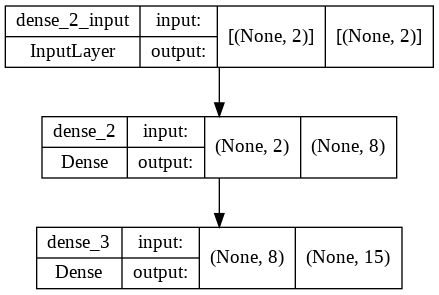

In [ ]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(autoencoder.decoder, to_file=dot_img_file, show_shapes=True)
# tf.keras.utils.plot_model(autoencoder.decoder)

In [ ]:
# Classification Report Modified
from sklearn.metrics import classification_report
import pandas as pd
report = {'label 1': {'precision':0.5,
             'recall':1.0,
             'f1-score':0.67,
             'support':1},
          'label 2': {'precision':0.55,
             'recall':1.0,
             'f1-score':0.67,
             'support':10}
}

indices = dict()
for i,k in enumerate(report.keys()):
    indices[k]=i

print(indices)

df = pd.DataFrame(report).T
df.rename(index=indices)

{'label 1': 0, 'label 2': 1}


,precision,recall,f1-score,support
0,0.50,1.0,0.67,1.0
1,0.55,1.0,0.67,10.0
